# Welcome to Fake News Classification

by: I Gusti Bagus Awienandra

### Import all dependencies

In [1]:
pip install pydot==1.3.0

In [2]:
pip install graphviz==0.10.1

In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras import callbacks
from keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

### Import Dataset

In [4]:
df = pd.read_csv('fake_or_real_news.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [6]:
df = df[:2001]

In [7]:
df.tail()

,Unnamed: 0,title,text,label
1996,6101,“Beware of the Shadow Government”: Ron Paul Ad...,\nThis article was written and originally publ...,FAKE
1997,1756,The GOP farce plods along: Why last night’s in...,"Of course, all the contenders genuflected at t...",REAL
1998,4120,"Fuming over Ryan, some conservative voices tur...",Rep. Mark Meadows (R-N.C.) has been able to co...,REAL
1999,3951,Germany's Merkel backs tighter refugee rules a...,As demonstrations erupted in Cologne on Saturd...,REAL
2000,343,Human remains found as search continues for 11...,"Human remains washed ashore Wednesday, as offi...",REAL


### Preprocessing

In [8]:
category = pd.get_dummies(df.label)

In [9]:
category_array = category.columns.tolist()

In [10]:
df_baru = pd.concat([df, category], axis=1)

In [11]:
df_baru = df_baru.drop(columns='label')

In [12]:
df_baru

,Unnamed: 0,title,text,FAKE,REAL
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,1
...,...,...,...,...,...
1996,6101,“Beware of the Shadow Government”: Ron Paul Ad...,\nThis article was written and originally publ...,1,0
1997,1756,The GOP farce plods along: Why last night’s in...,"Of course, all the contenders genuflected at t...",0,1
1998,4120,"Fuming over Ryan, some conservative voices tur...",Rep. Mark Meadows (R-N.C.) has been able to co...,0,1
1999,3951,Germany's Merkel backs tighter refugee rules a...,As demonstrations erupted in Cologne on Saturd...,0,1


In [13]:
sentence = df_baru['text'].values
label = df_baru[category_array].values
train_sentence, test_sentence, train_label, test_label = train_test_split(sentence, label, test_size=0.2)

### Create Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=5000, split=' ')

### Fit Sentence

In [15]:
tokenizer.fit_on_texts(train_sentence) 
tokenizer.fit_on_texts(test_sentence)

### Convert Text to Index

In [16]:
train_sequences = tokenizer.texts_to_sequences(train_sentence)
test_sequences = tokenizer.texts_to_sequences(test_sentence)

In [17]:
vocab_size = len(tokenizer.word_index)+1

### Padding

In [18]:
train_padded = pad_sequences(train_sequences) 
test_padded = pad_sequences(test_sequences)

### Create Model

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [20]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          872512    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 909,954
Trainable params: 909,954
Non-trainable params: 0
_________________________________________________________________
None


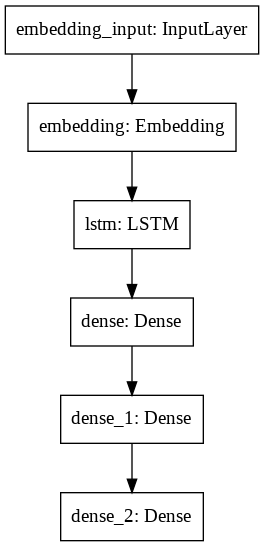

In [22]:
plot_model(model, to_file='submission1-fake-news.png')

### Create Callbacks

In [23]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nYour Accuracy >95%!")
      self.model.stop_training = True

In [24]:
callbacks = myCallback()

### Fit Model

In [25]:
history = model.fit(train_padded, train_label, epochs=10, 
                    validation_data=(test_padded, test_label), verbose=2, callbacks=[callbacks], batch_size = 128)

Epoch 1/10
13/13 - 310s - loss: 0.8493 - accuracy: 0.5125 - val_loss: 0.8298 - val_accuracy: 0.4963
Epoch 2/10
13/13 - 304s - loss: 0.8091 - accuracy: 0.5769 - val_loss: 0.7856 - val_accuracy: 0.7157
Epoch 3/10
13/13 - 310s - loss: 0.7265 - accuracy: 0.7925 - val_loss: 0.8449 - val_accuracy: 0.5387
Epoch 4/10
13/13 - 305s - loss: 0.6550 - accuracy: 0.8319 - val_loss: 0.6584 - val_accuracy: 0.7681
Epoch 5/10
13/13 - 303s - loss: 0.5348 - accuracy: 0.9081 - val_loss: 0.5692 - val_accuracy: 0.7855
Epoch 6/10
13/13 - 297s - loss: 0.3643 - accuracy: 0.9381 - val_loss: 0.4855 - val_accuracy: 0.8105
Epoch 7/10

Your Accuracy >95%!
13/13 - 302s - loss: 0.2072 - accuracy: 0.9669 - val_loss: 0.4849 - val_accuracy: 0.8529


### Plotting

#### Plot Model Loss

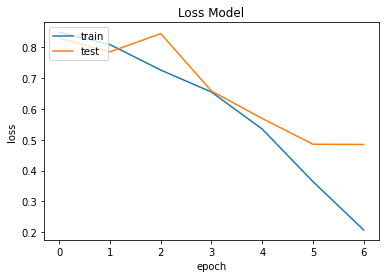

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Plot Model Accuracy

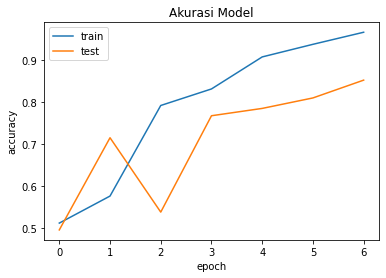

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()